# Analyze Results from Classification models

<h2>Background</h2>

I found that running different models through Jupyter notebook just wasn't stable enough. The process would either crash or hang and found the speed much slower than if I ran them as a standalone programs. I also found that if I broke the steps down into different programs, it would run faster and was more reliable for me to check on results.

Here is a list of programs that I used to generate various feature files and results:

| File Name | Description | Helper Classes | Sample Config File |
|-----------|-------------|----------------|--------------------|
| [tsv_to_csv.py](tsv_to_csv.py) | I found that pandas did not handle reading in raw amazong review files (tsv) correctly. There were line breaks in the data file that caused pandas to be confused and would merge in multiple lines into one column cell which would sku the data. Needed to write this to convert the tsv to csv so pandas can read the data properly | N/A | N/A |
| [amazon_review_preprocessor.py](amazon_review_preprocessor.py) | Takes in converted amazon review csv file does pre-processing/cleaning of the data | [util.TextProcessor.py](util/TextProcessor.py) | N/A |
| [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py) | Takes in preprocessed file generated from [amazon_review_preprocessor.py](amazon_review_preprocessor.py) and generate BoW or TFIDF feature files with different parameters. Parameters supported: various max_df, min_df, ngrams | [nlp.feature_util.py](nlp/feature_util.py) | [2019-05-21-amazon_review_feature_generation_config-bow.py](config/2019-05-21-amazon_review_feature_generation_config-bow.csv) |
| [generate_lda_features.py](generate_lda_features.py) | After processing data through [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py), I used this program to do Topic Modeling using LDA with this program. Current setting picks 20 topics and generate resulting data files | N/A | [2019-05-21-amazon_review_generate_lda_feature_config-tfidf.cvs](config/2019-05-21-amazon_review_generate_lda_feature_config-tfidf.csv) |
| [run_classifiers.py](run_classifiers.py) | This was originally a python notebook that would take hours and hours to run. But the original notebook also combined the function of generating BoW and TF-IDF with various parameters encoding as well as running KNN and LogisticRegression with various parameters. This also generates reports using sklearn's classification_report for different models which we will interpret here. | [models/ClassifierRunner.py](models.ClassifierRunner.py) | [2019-05-23-run_classifiers-config.csv](config/template-run_classifiers.csv) |


<h2>Encoding</h2>

For this notebook, we are analyzing results of different classification models using features generated by text encoding. The two encoding algorithms we used are Word2Vec and FastText

Feature vectors are generated in the following manner:
    * All pre-processed review bodies are passed to encoder to build vocabulary
    * For each review, a vector is created by the encooder for every word.
    * The final vector for the review is an average of word vectors that of all words in that review
    
<h2>Number of Features</h2>

Because encoding the reviews take quite a long time. I was only able to run the results through models with 200, 400, and 1600 features.

I'm still in the process of generating 4000 feature vectors and it's been running for over 2 days.

<h2>Samples</h2>

Once features are generated, running them through the models is relatively fast. So, for this round, I used the full 110k features instead of 50k features in previous notebooks.

<h2>Models</h2>

I am still using the final 3 models we used in previous notebook: Logistic Regressionwith Balanced Weight, lightGBM, and CatBoost

<h2>SMOTE</h2>

Since SMOTE did not yeild better results the last round, I did not synthetically generate features for under-represented classes this time around


<h2>Plots</h2>

To reduce the size of the notebook, I also moved some of the plotting code into this class since I was reusing them across notebooks: [plot_util.py](util/plot_util.py)

<h2>Here is the code snippet on how the features were generated</h2>

For full code, please look at [run_classifiers.py](run_classifiers.py) and [feature_util.py](util/feature_util.py)

``` python
def get_review_vector(model, review):
    # returns a list of word vectors for all words im review
    wpt = WordPunctTokenizer()
    word_vectors = [model.wv.get_vector(word) for word in wpt.tokenize(review)]
    #     print(len(word_vectors))
    # average all word vectors to come up with final vector for the review
    return np.average(word_vectors, axis=0)


# generate new feature DF
def get_feature_df(model, df: pd.DataFrame) -> pd.DataFrame:
    f_df = pd.DataFrame()
    for index, review in df.iteritems():
        feature_vector = get_review_vector(model, review)
        # turn this into dictionary so we can add it as row to DF
        feature_dict = dict(enumerate(feature_vector))
        f_df = f_df.append(feature_dict, ignore_index=True)
        if index % 10000 == 0:
            log.info(f"Generating vector for index: {index}")
    return f_df

def generate_word2vec_file(x: pd.DataFrame,
                           y: pd.Series,
                           description: str,
                           feature_size: int,
                           window_context: int,
                           min_word_count: int,
                           sample: float,
                           iterations: int,
                           feature_column: str,
                           timer: Timer
                           ):
    """
    generate features using word2vec
    :param x:
    :param y:
    :param description:
    :param feature_size:
    :param window_context:
    :param min_word_count:
    :param sample:
    :param iterations:
    :return:
    """
    log.info("generating word2vec")
    log.debug(f'{x.head()}')
    wpt = WordPunctTokenizer()

    timer.start_timer(TOKENIZE_TIME_MIN)
    documents = [wpt.tokenize(review) for review in x.array]
    timer.end_timer(TOKENIZE_TIME_MIN)

    timer.start_timer(VECTORIZE_TIME_MIN)
    w2v_model = Word2Vec(documents,
                         size=feature_size,
                         window=window_context,
                         min_count=min_word_count,
                         sample=sample,
                         iter=iterations
                         )
    timer.end_timer(VECTORIZE_TIME_MIN)

    model_file = f"models/{description}-{len(x)}-{feature_size}.model"
    log.info(f'Writing model file: {model_file}')
    timer.start_timer(MODEL_SAVE_TIME_MIN)
    w2v_model.save(model_file)
    timer.end_timer(MODEL_SAVE_TIME_MIN)

    feature_df = get_feature_df(w2v_model, x)
    return write_to_file(feature_df, y, feature_column, description, include_lda=False
```

<h3>Fasttext</h3>

Here is the model constructor for FastText - all other code is the same

``` python
    ft_model = FastText(documents,
                        size=feature_size,
                        window=window_context,
                        min_count=min_word_count,
                        sample=sample,
                        iter=iterations
                        )
```

<h3>Parameters</h3>

For both Word2Vec and FastText, we used the following parameters:

* windows_context = 30
* min_word_count = 1
* sample = 0.001

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import util.plot_util as pu


%matplotlib inline
sns.set()

In [90]:
DATA_FILE="reports/2019-06-11-run_classifiers-report-encodings.csv"

report = pd.read_csv(DATA_FILE)
report["total_size"] = report["train_examples"] + report["test_examples"]
report.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,total_time_min,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,config_file,total_size
0,0.656333,0.599662,0.724834,3914,0.090950,0.281768,0.054226,1881,0.187285,0.344573,...,1.74,83931,1600,4.91,0.586381,0.579306,0.648259,27978,config/2019-06-11-run_classifiers-marmoset.csv,111909
1,0.662271,0.588598,0.757026,3914,0.048804,0.297619,0.026582,1881,0.224659,0.351171,...,1.54,83931,1600,17.52,0.591554,0.587388,0.654479,27978,config/2019-06-11-run_classifiers-marmoset.csv,111909
2,0.650765,0.649771,0.651763,3914,0.289731,0.234886,0.377990,1881,0.286727,0.242838,...,1.56,83931,1600,2.59,0.593808,0.640270,0.567196,27978,config/2019-06-11-run_classifiers-marmoset.csv,111909
3,0.670280,0.610889,0.742463,3914,0.096703,0.279188,0.058480,1881,0.203786,0.348904,...,1.56,83931,1600,4.86,0.596183,0.586964,0.654085,27978,config/2019-06-11-run_classifiers-marmoset.csv,111909
4,0.677552,0.599332,0.779254,3914,0.057005,0.312169,0.031366,1881,0.235777,0.338484,...,1.54,83931,1600,15.45,0.601577,0.596343,0.660197,27978,config/2019-06-11-run_classifiers-marmoset.csv,111909


<h2>Models</h2>

* CB = CatBoost
* LRB100 = Logistic Regression with Balanced Weight, 100 iterations
* lGBM = lightGBM

Default parameters were used for all 3 models


In [91]:
# Set up variables for the rest of this notebook
MODELS = sorted(report["model_name"].unique().tolist())
MODELS

['CB', 'LRB100', 'lGBM']

In [92]:
def split_desc(x):
    desc = x["description"]
    s_desc = desc.split("-")
    if len(s_desc) == 6:
        s_desc.append("n/a")
#     print(f'desc: {desc} len: {len(s_desc)}')
    return pd.Series(s_desc)
    

s = report[["description","status", "model_name", "test_features"]].copy()
new_df = s.apply(split_desc, axis=1)
new_df = new_df.rename({1: "embedding"}, axis=1)
# get a list of unique models - we will use this later
report = report.join(new_df["embedding"])
s.join(new_df["embedding"])


,description,status,model_name,test_features,embedding
0,review_body-fasttext-111909-1600-nolda-nosmote...,success,lGBM,1600,fasttext
1,review_body-fasttext-111909-1600-nolda-nosmote...,success,CB,1600,fasttext
2,review_body-fasttext-111909-1600-nolda-nosmote...,success,LRB100,1600,fasttext
3,review_body-word2vec-111909-1600-nolda-nosmote...,success,lGBM,1600,word2vec
4,review_body-word2vec-111909-1600-nolda-nosmote...,success,CB,1600,word2vec
5,review_body-word2vec-111909-1600-nolda-nosmote...,success,LRB100,1600,word2vec
6,review_body-fasttext-111909-200-nolda-nosmote-...,success,lGBM,200,fasttext
7,review_body-fasttext-111909-200-nolda-nosmote-...,success,CB,200,fasttext
8,review_body-fasttext-111909-200-nolda-nosmote-...,success,LRB100,200,fasttext
9,review_body-word2vec-111909-200-nolda-nosmote-...,success,lGBM,200,word2vec


In [93]:
report["label"] = report.apply(lambda x: f'{x["model_name"]}-{x["embedding"]}-{x["description"]}', axis=1)
# report = report.drop(labels=["model_name", "description"], axis=1).sort_values(["label"])
report = report.sort_values(["model_name", "train_features", "label"])
report.head(2)

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,config_file,total_size,embedding,label
7,0.657368,0.587219,0.746551,3914,0.035156,0.215569,0.019139,1881,0.222163,0.347863,...,200,4.18,0.583054,0.575221,0.649618,27978,config/2019-06-09-run_classifiers.csv,111909,fasttext,CB-fasttext-review_body-fasttext-111909-200-no...
10,0.671139,0.596739,0.766735,3914,0.055291,0.267281,0.030835,1881,0.230609,0.341032,...,200,4.09,0.596211,0.589458,0.657159,27978,config/2019-06-09-run_classifiers.csv,111909,word2vec,CB-word2vec-review_body-word2vec-111909-200-no...


## Average Train time

* KNN is the slowest with some outliers
* Logsitic Regression has large variations in train times

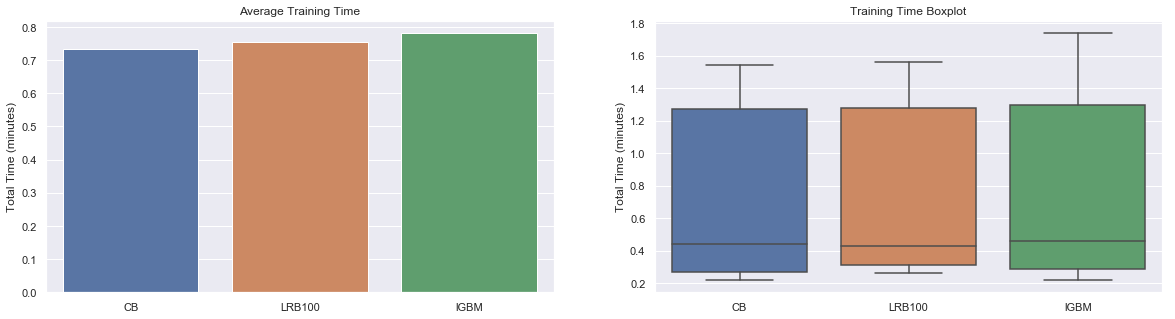

In [94]:
f, a = plt.subplots(1, 2, figsize=(20,5))

avg_train_times = []
for model in MODELS:
    avg_train_times.append(report[report["label"].str.startswith(f"{model}-")].total_time_min.mean())
    
sns.barplot(x=MODELS, y=avg_train_times, ax=a[0])
a[0].set_ylabel("Total Time (minutes)")
_ = a[0].set_title("Average Training Time")


sns.boxplot(data=report, x="model_name", y="total_time_min", ax=a[1])
a[1].set_ylabel("Total Time (minutes)")
a[1].set_xlabel("")
_ = a[1].set_title("Training Time Boxplot")


## Logistic Regression Seems to still do the best when it comes to F1, precision, and recall

## Also larger feature sizes seems ot improve scores

## Word2Vec seems to be doing better than FastText in precision but doesn't change the average scores for the others

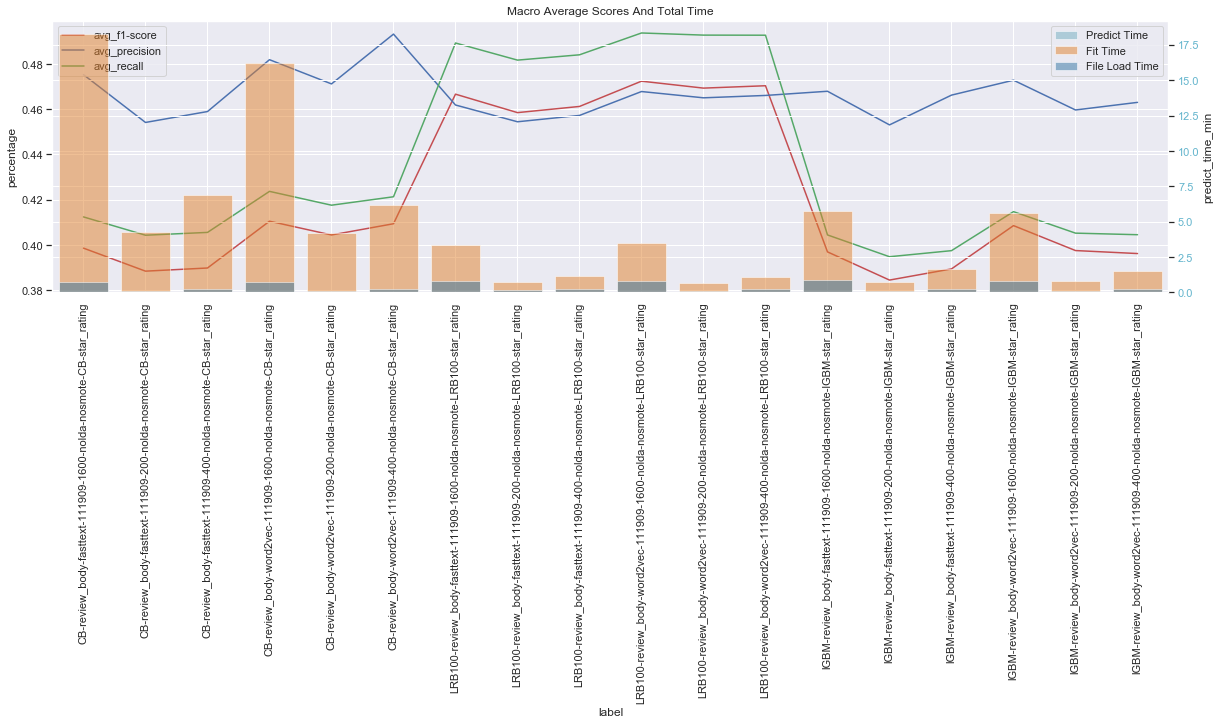

In [95]:
pu.plot_macro_data(report)

### Logistic Regression average F1 score does better than the rest with less standard deviation

In [96]:
for model in MODELS:
    model_df = macro_scores[macro_scores["label"].str.contains(model)]
    print(f'\n{model} mean: {model_df["macro avg_f1-score"].mean()}')
    print(f'{model} std: {model_df["macro avg_f1-score"].std()}')


CB mean: 0.4001511151666666
CB std: 0.009567577667849199

LRB100 mean: 0.46640195516666666
LRB100 std: 0.005473993460866624

lGBM mean: 0.39548067933333336
lGBM std: 0.008194655420054492


## F1 Score By Class

In [97]:
f1_class = report[CLASS_F1_COLS]
f1_class.head()

,1_f1-score,2_f1-score,3_f1-score,4_f1-score,5_f1-score,label
7,0.657368,0.035156,0.222163,0.218951,0.808264,CB-review_body-fasttext-111909-200-nolda-nosmo...
10,0.671139,0.055291,0.230609,0.249015,0.815874,CB-review_body-word2vec-111909-200-nolda-nosmo...
13,0.654964,0.032593,0.222343,0.231125,0.807837,CB-review_body-fasttext-111909-400-nolda-nosmo...
16,0.671795,0.064891,0.241164,0.253568,0.815318,CB-review_body-word2vec-111909-400-nolda-nosmo...
1,0.662271,0.048804,0.224659,0.244235,0.812810,CB-review_body-fasttext-111909-1600-nolda-nosm...


# Summary

* CatBoost
    * Precision for FastText seems to go up for star-rating 2. Not significant difference for Word2Vec
    * Precision for CatBoost seems to be the highest out of the 3 models
    * Overall, CatBoost seems to have issues identifying star ratings in general since recall is low
* Logistic Regression
    * Still the best model soo far. Even though distribution of 2 star ratings is lowest, it is able to do pretty well compared with 3 and 4 Star ratings
    * No significant differences when we increase the number of features in our word vectoors
* lighGBM
    * Precision overall is better than the owther 2 models even though F1 score is somewhere between CatBoost and Recall
    * Like CatBoost, lightGBM seems to have difficulty identifying ratings in general since recall is low

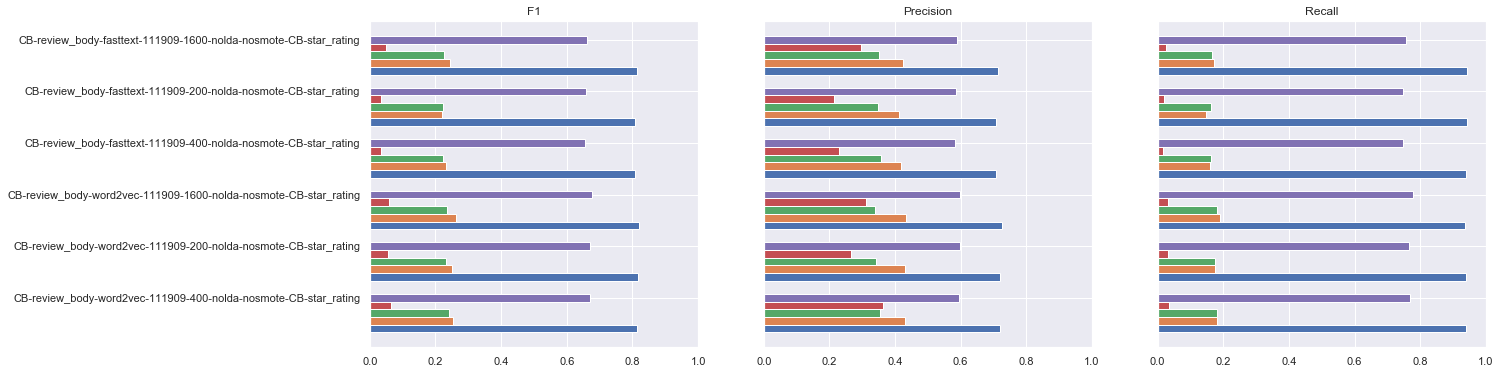

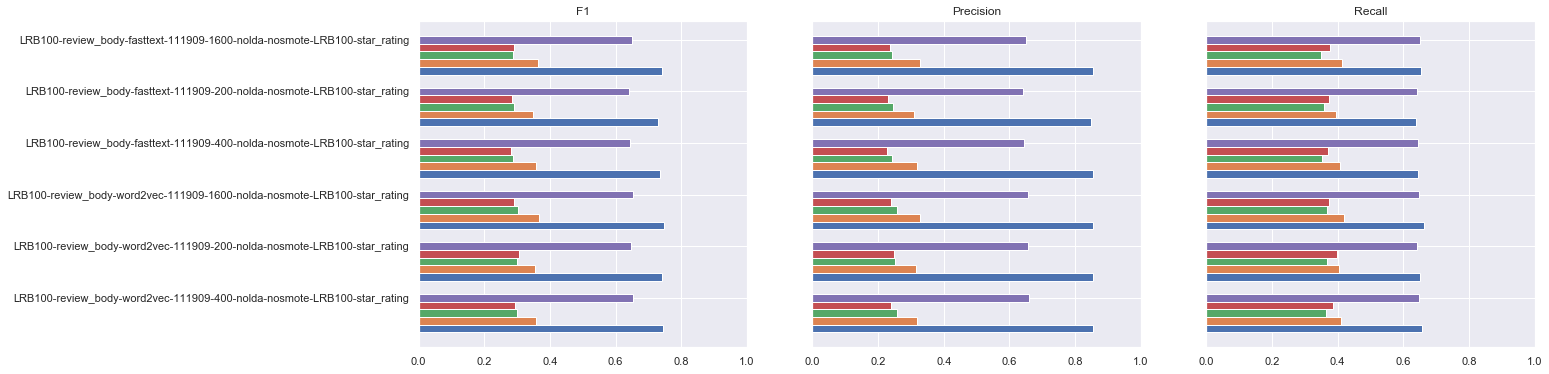

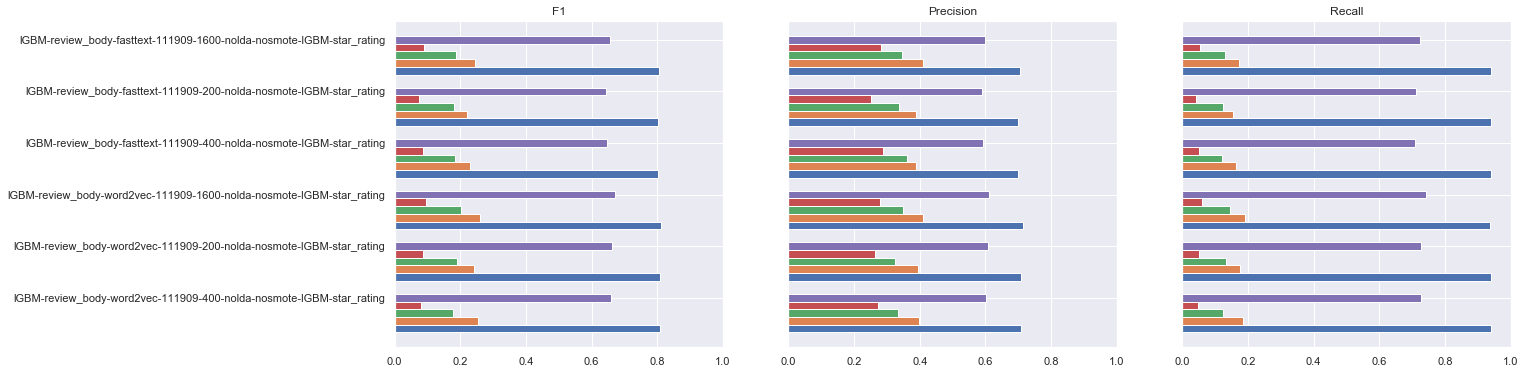

In [98]:
pu.plot_score_histograms(report)

# Confusion Matrix

Since number of features doesn't seem to make significant difference, we will pick the models with 1600 features since training time is relatively low from now on

## Word2Vec Confusion Matrix

* CatBoots
    * 2-star ratiings are rarely identified as 2-star ratings
    * 3-star ratings are most often misclassified as 2 or 4-stars
* Logistic Regression
    * Classified the most 2-star ratings out of the 3 models
    * 2-star are most often misclassified as 1 star
    * 3-star ratings are most often misclassified as 2-star
* lightGBM
    * 3-star ratings are most often misclassified as 2-star
    
    
In all models:
    * 2-star are most often misclassified as 1 star
    * 4-star ratings are most often misclassified as 5 stars
    
    
### This seems so suggest that if we turn this into a 2-class classification model, our accuracy would drastically improve
    

In [99]:
for model in MODELS:
    print(model)
    matrix = report[(report.embedding == "word2vec") & 
                 (report.train_features == 1600) & 
                 (report.model_name == model)]["confusion_matrix"].iloc[0]
    matrix = matrix.replace('\\n', '\n')
    print(matrix)

CB
[[ 3050    56   188    89   531]
 [  904    59   268   151   499]
 [  603    52   460   436   992]
 [  233    12   306   888  3254]
 [  299    10   137   487 14014]]
LRB100
[[2532  866  326  103   87]
 [ 553  701  428  129   70]
 [ 280  620  934  499  210]
 [ 139  312  980 1963 1299]
 [ 343  423  948 3318 9915]]
lGBM
[[ 2906   117   155   126   610]
 [  813   110   205   192   561]
 [  539   101   366   475  1062]
 [  212    38   211   893  3339]
 [  287    28   112   495 14025]]


## Fasttext Confustion Matrix

Seeing the same behavior as Word2Vec for the various models with the exception of lightGBM
    * 3-star ratings tends to be misclassifed as 1-star ratings whereas with Word2Vec it tended to classify them as 2-star ratings

In [100]:
for model in MODELS:
    print(model)
    matrix = report[(report.embedding == "fasttext") & 
                 (report.train_features == 1600) & 
                 (report.model_name == model)]["confusion_matrix"].iloc[0]
    matrix = matrix.replace('\\n', '\n')
    print(matrix)

CB
[[ 2963    50   182    88   631]
 [  895    50   235   155   546]
 [  578    43   420   417  1085]
 [  272    16   254   805  3346]
 [  326     9   105   434 14073]]
LRB100
[[2551  863  319   84   97]
 [ 554  711  421  125   70]
 [ 292  653  890  518  190]
 [ 133  332  989 1934 1305]
 [ 396  468 1046 3254 9783]]
lGBM
[[ 2837   108   144   114   711]
 [  810   102   182   180   607]
 [  530    93   327   427  1166]
 [  243    36   198   817  3399]
 [  311    23    98   461 14054]]


# Let's look at Embedding compared to Previous features (ie, BoW and TFIDF) to see if there is a different 

In [101]:
DATA_FILE="reports/2019-06-11-run_classifiers-report-compare.csv"

c_report = pd.read_csv(DATA_FILE)
c_report["total_size"] = c_report["train_examples"] + c_report["test_examples"]
c_report["label"] = c_report.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)
# report = report.drop(labels=["model_name", "description"], axis=1).sort_values(["label"])
c_report = c_report.sort_values(["model_name", "feature_generation", "label"])

c_report.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,config_file,total_size,label
6,0.658699,0.582160,0.758410,1635,0.063107,0.317073,0.035040,742,0.183150,0.359195,...,48863,10020,53.70,0.614210,0.616178,0.677680,12500,NaN,61363,CB-review_body-bow-df_default-ngram12-50000-10...
9,0.666667,0.590288,0.765749,1635,0.054388,0.328358,0.029650,742,0.178493,0.348571,...,48863,10020,78.08,0.612787,0.613388,0.678000,12500,NaN,61363,CB-review_body-tfidf-df_default-ngram12-50000-...
1,0.662271,0.588598,0.757026,3914,0.048804,0.297619,0.026582,1881,0.224659,0.351171,...,83931,1600,17.52,0.591554,0.587388,0.654479,27978,config/2019-06-11-run_classifiers-marmoset.csv,111909,CB-review_body-fasttext-111909-1600-nolda-nosm...
4,0.677552,0.599332,0.779254,3914,0.057005,0.312169,0.031366,1881,0.235777,0.338484,...,83931,1600,15.45,0.601577,0.596343,0.660197,27978,config/2019-06-11-run_classifiers-marmoset.csv,111909,CB-review_body-word2vec-111909-1600-nolda-nosm...
8,0.640244,0.638298,0.642202,1635,0.204733,0.173023,0.250674,742,0.292747,0.264706,...,48863,10020,11.35,0.619382,0.651112,0.597600,12500,NaN,61363,LRB100-review_body-bow-df_default-ngram12-5000...


## Interpreting Results - Embedding vs Traditional Feature Generation (BoW and TFIDF)

<h3>CatBoost</h3>

    * almost no difference whether features are generated from embedding or not
    * only difference is slight improvement for BoW for 2-star rating and 4-star rating precision
    * embedding has slightly higher recall for 3-star ratings

<h3>Logistic Regression</h3>

    * embedding does better then BoW and TFIDF for 2-star ratings for all 3 scores score but slightly worse for 5-star ratings

<h3>lightGBM</h3>

    * embedding actually does worse for 2-star ratings in F1 score but performs better for precision and recall
    * almost no differences in all other classes

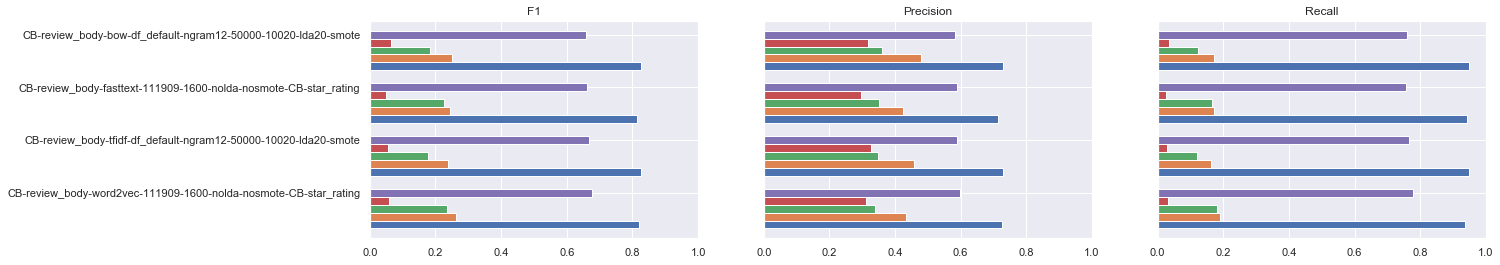

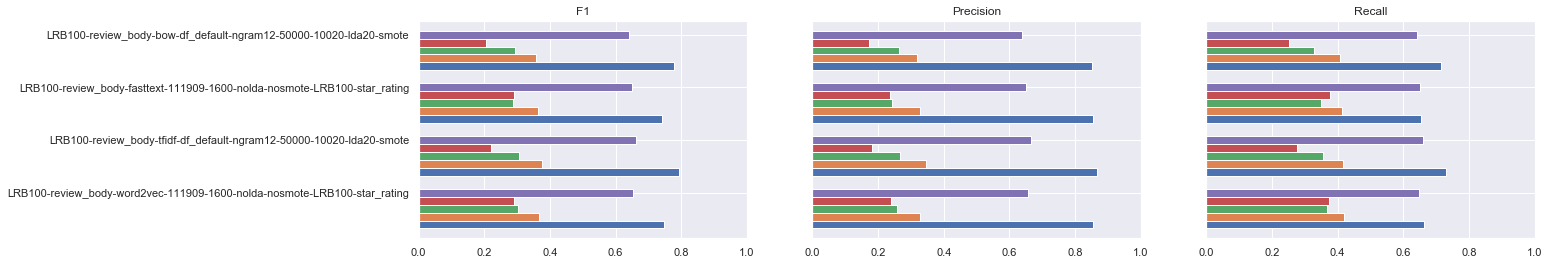

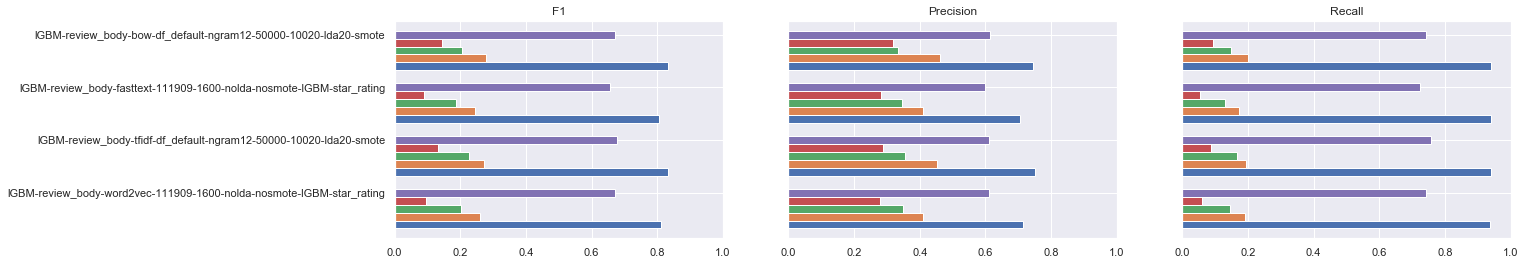

In [102]:
pu.plot_score_histograms(c_report)